In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
torch.manual_seed(0)


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

C:\Users\adhar\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\adhar\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### Generator
We created a generator with four layers: three hidden layers and one output layer. We wrote a function to build a single block for the generator's neural network, much like we did with vanilla GAN.

We need to examine what layer is being formed in DCGAN because the activation function for the output layer will be different.

We gave a forward pass method at the end of the generator class that takes in a noise vector and uses the neural network to build an image of the output dimension. We also created a noise vector using a function. These are the same functions that we used in Vanilla GAN.

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
gen = Generator()
num_test = 100
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

### Discriminator
In this discriminator's neural network, we used three layers. We constructed the function to create a single neural network block for the discriminator in the same way we did for the generator.

In [4]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: 
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

### Parameters:
  *   criterion: Loss function
  *   n_epochs: Number of times you go over the full dataset when training
  *   z_dim: Noice Vector dimension
  *   display_step: How often should the images be displayed
  *   batch_size: Number of images per forward/backward pass
  *   lr: Learning rate
  *   beta_1, beta_2: Momentum term
  *   device: Device type, we are using a GPU (which runs CUDA).


In [5]:
num_test = 100
gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))
test_hidden_block = disc.make_disc_block(1,5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)
disc_output = disc(test_images)

In [6]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [7]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.8831329421401016, discriminator loss: 0.5323834472894672


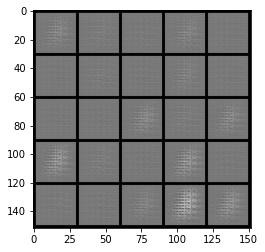

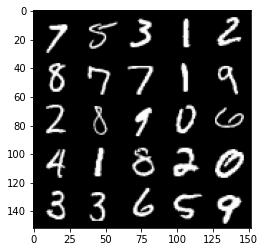

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.924486645698547, discriminator loss: 0.258056080803275


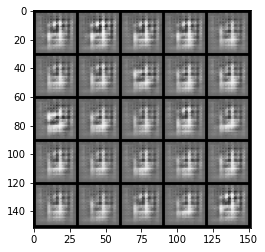

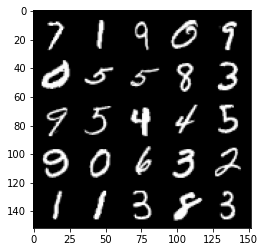

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.6044974526166926, discriminator loss: 0.4142602822780612


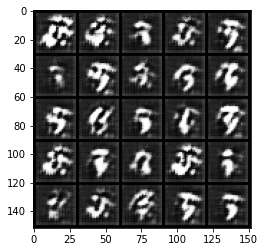

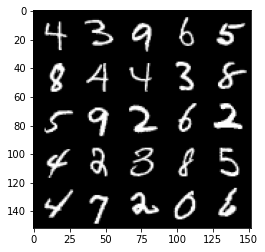

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.0918175252676006, discriminator loss: 0.5330084357857702


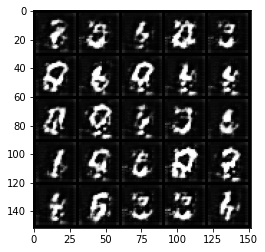

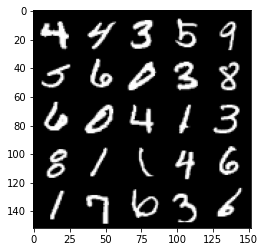

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.9522029702663419, discriminator loss: 0.579934602737427


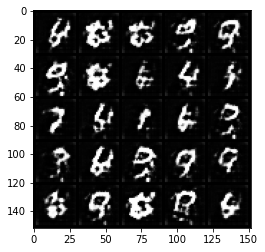

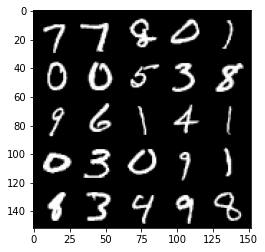

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.8662063161134723, discriminator loss: 0.6163116676807406


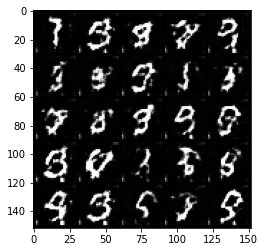

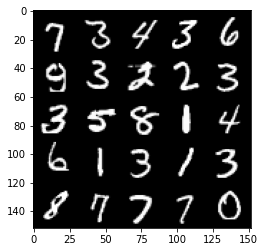

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.8399763692617412, discriminator loss: 0.6251661217212684


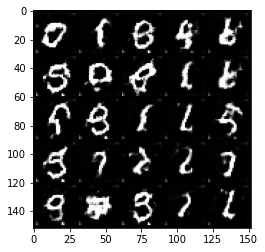

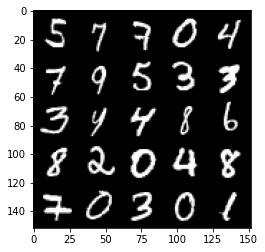

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.8344007986187926, discriminator loss: 0.6408043394088746


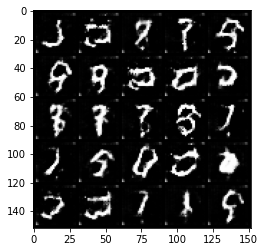

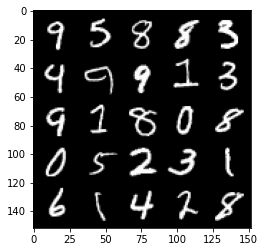

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.7955630180239681, discriminator loss: 0.6598872849941253


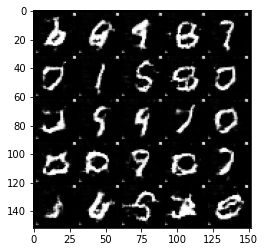

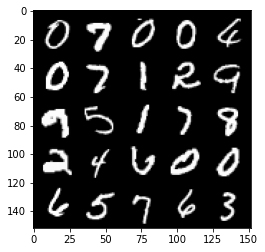

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.7806793879270557, discriminator loss: 0.6661617417335511


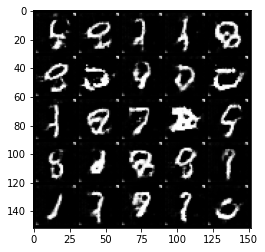

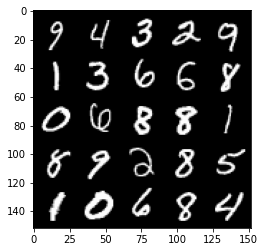

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.7623546400666232, discriminator loss: 0.6681584583520891


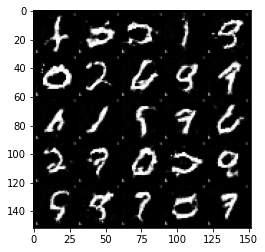

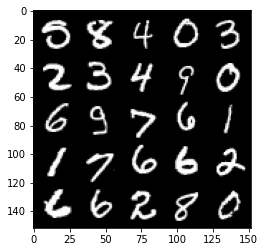

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7583846716284758, discriminator loss: 0.6727447041273119


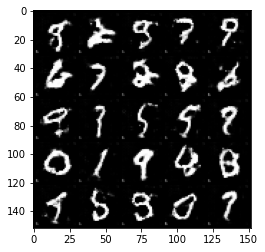

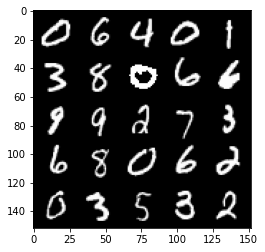

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7511477989554407, discriminator loss: 0.6772338443994521


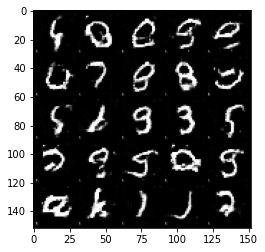

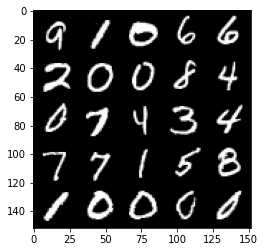

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7481320048570638, discriminator loss: 0.683634925246238


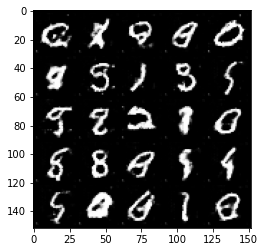

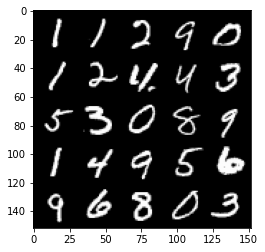

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7434453123807905, discriminator loss: 0.6877180485725403


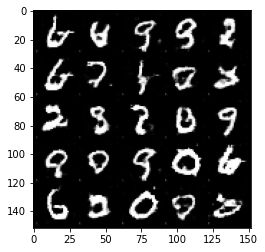

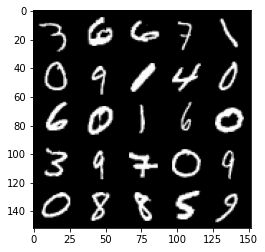

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7327934036254875, discriminator loss: 0.688597694277764


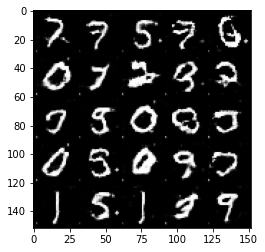

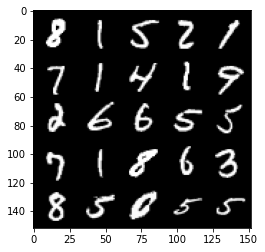

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.733422793030739, discriminator loss: 0.6897542530298245


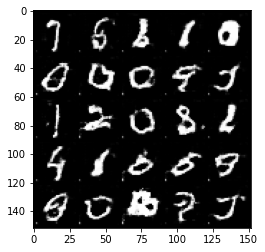

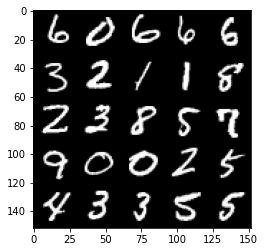

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7301458936929701, discriminator loss: 0.6921756703853613


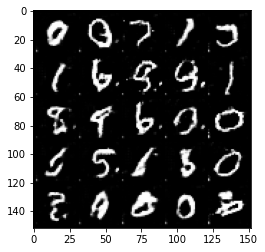

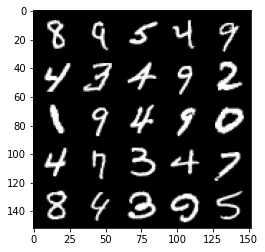

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7244541637897488, discriminator loss: 0.6921309150457379


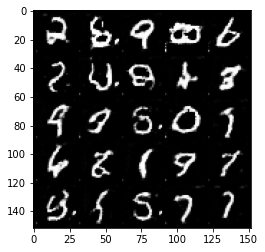

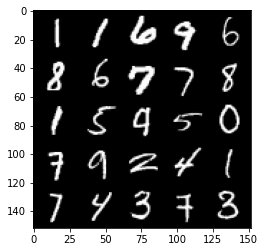

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7238282337188728, discriminator loss: 0.6934994863271712


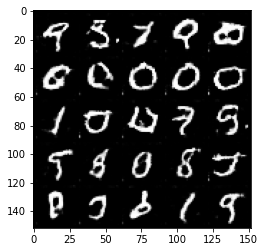

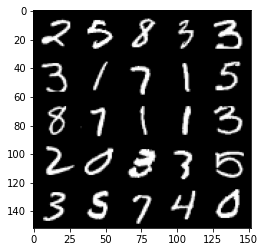

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7191474775075908, discriminator loss: 0.6941895762681953


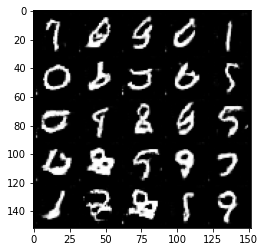

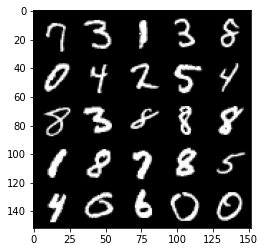

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.7160175002217292, discriminator loss: 0.6962710421085344


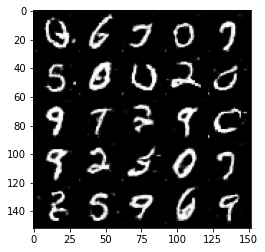

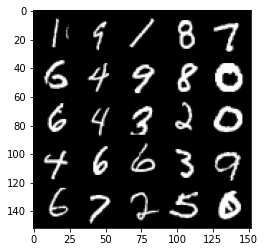

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.714867567300796, discriminator loss: 0.695081966876983


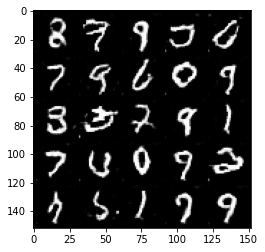

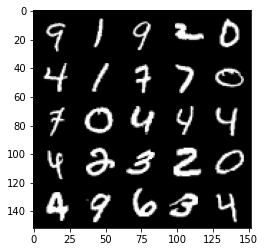

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.7049442018270482, discriminator loss: 0.7011976466178893


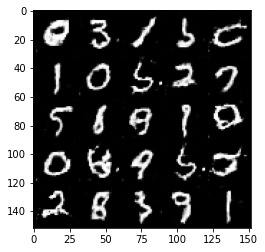

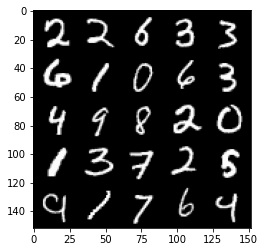

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.7111793571710585, discriminator loss: 0.6968843005895609


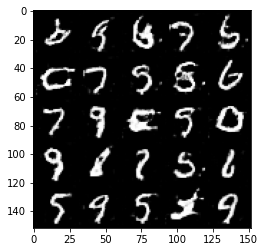

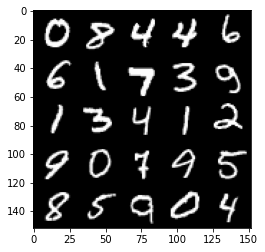

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.7105895099639904, discriminator loss: 0.6967690129280092


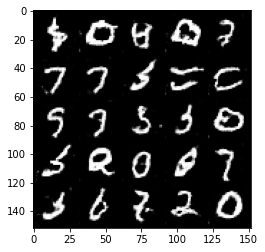

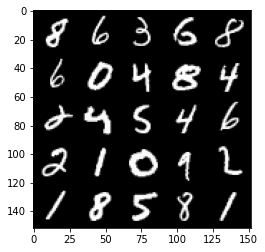

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7109573608636858, discriminator loss: 0.6958537585735325


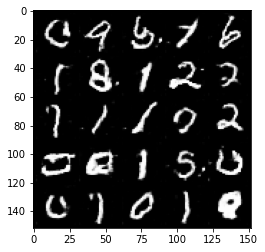

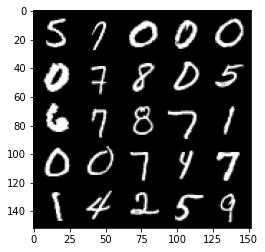

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.7068202796578404, discriminator loss: 0.6972013343572617


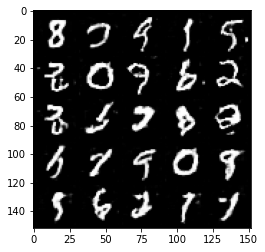

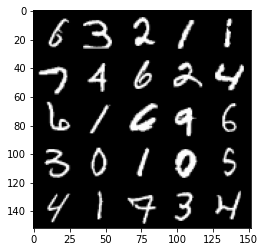

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.7072121419310567, discriminator loss: 0.6964558023214349


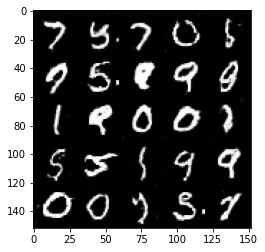

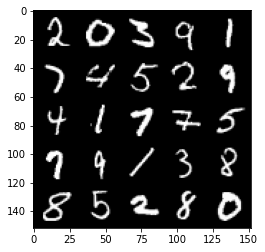

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.7064618856906884, discriminator loss: 0.6983577201366421


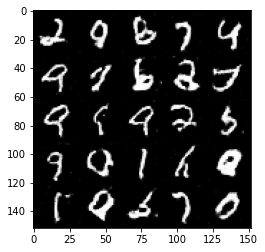

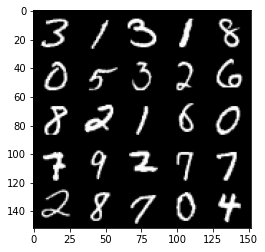

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.7059041727185248, discriminator loss: 0.6961658487319948


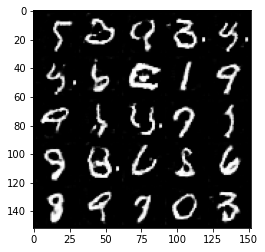

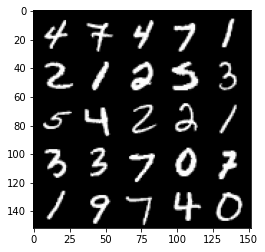

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.7063662403821945, discriminator loss: 0.696263154029846


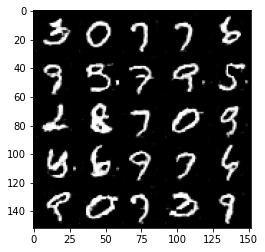

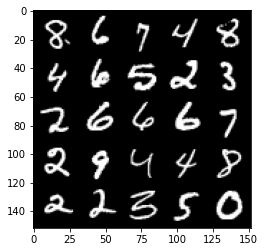

In [8]:
n_epochs = 35
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        mean_discriminator_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        mean_generator_loss += gen_loss.item() / display_step
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
